# PART 1: Train the VAE

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ======================================
# Device setup
# ======================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ======================================
# 0. Define VAE Architecture
# ======================================
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc_fc1 = nn.Linear(28*28, 400)
        self.enc_fc_mu = nn.Linear(400, latent_dim)
        self.enc_fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.dec_fc1 = nn.Linear(latent_dim, 400)
        self.dec_fc2 = nn.Linear(400, 28*28)

    def encode(self, x):
        x = x.view(x.size(0), -1)
        h1 = F.relu(self.enc_fc1(x))
        mu = self.enc_fc_mu(h1)
        logvar = self.enc_fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h2 = F.relu(self.dec_fc1(z))
        out = torch.sigmoid(self.dec_fc2(h2))
        out = out.view(-1, 1, 28, 28)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar



Using device: cuda


In [5]:
# FashionMNIST images are 28x28 grayscale
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [6]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

def vae_loss_annealed(recon_x, x, mu, logvar, beta):
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta*kl_loss, recon_loss, kl_loss


Epoch 1: Train Loss=39.87, Val Loss=32.30
Epoch 2: Train Loss=29.68, Val Loss=28.32
Epoch 3: Train Loss=27.72, Val Loss=27.21
Epoch 4: Train Loss=26.91, Val Loss=26.60
Epoch 5: Train Loss=26.40, Val Loss=26.21
Epoch 6: Train Loss=26.06, Val Loss=25.87
Epoch 7: Train Loss=25.83, Val Loss=25.72
Epoch 8: Train Loss=25.62, Val Loss=25.54
Epoch 9: Train Loss=25.46, Val Loss=25.31
Epoch 10: Train Loss=25.30, Val Loss=25.21


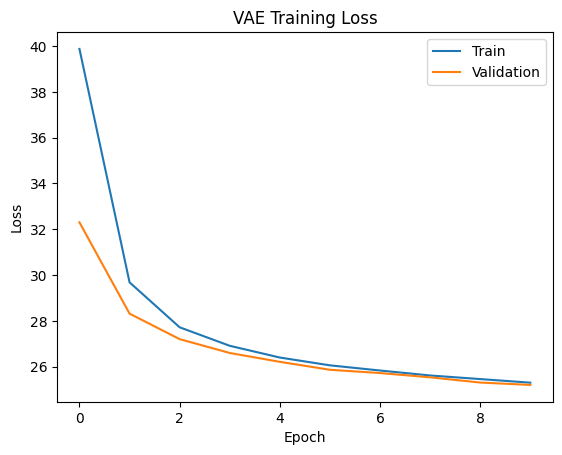

In [7]:
latent_dim = 20
model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        loss, _, _ = vae_loss(recon_x, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss, _, _ = vae_loss(recon_x, x, mu, logvar)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader.dataset))
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.2f}, Val Loss={val_losses[-1]:.2f}")

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# PART 2: Visualize Reconstructions & Generations

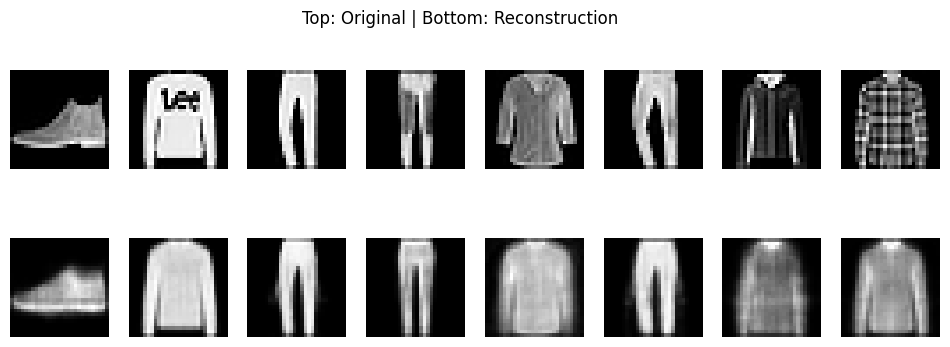

In [8]:
model.eval()

x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    recon_x, _, _ = model(x)

# Show first 8 examples
n = 8
plt.figure(figsize=(12, 4))

for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(x[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

    # Reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstruction")
plt.show()


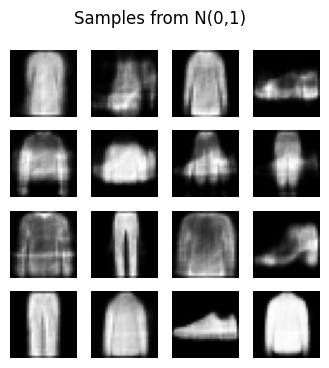

In [9]:
z = torch.randn(16, model.latent_dim).to(device)

with torch.no_grad():
    samples = model.decode(z)

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Samples from N(0,1)")
plt.show()


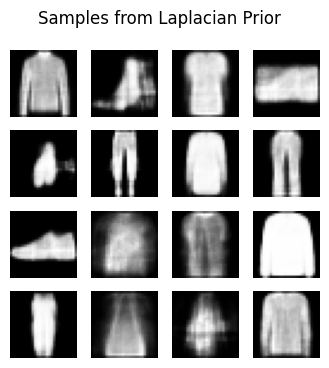

In [10]:
laplace = torch.distributions.Laplace(0, 1)
z_laplace = laplace.sample((16, model.latent_dim)).to(device)

with torch.no_grad():
    samples_laplace = model.decode(z_laplace)

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples_laplace[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Samples from Laplacian Prior")
plt.show()


# PART 3: Posterior Collapse Investigation

After training the Variational Autoencoder on the FashionMNIST dataset, the reconstruction loss consistently decreases, indicating that the model is learning to reproduce input images reasonably well. The reconstructed images resemble the original inputs in terms of overall shape and structure, though they appear slightly blurry, which is a known characteristic of VAEs trained with pixel-wise reconstruction losses.

However, when generating new samples by sampling latent vectors from the prior distribution and decoding them, the generated images appear highly similar to one another and lack diversity. In some cases, the generated samples resemble an average or uniform “blob” rather than distinct clothing items. This behavior suggests that, despite successful reconstruction, the generative capability of the model is limited and the latent space is not being effectively utilized to encode diverse features.

In [11]:
model.eval()

total_recon = 0
total_kl = 0

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        _, recon_loss, kl_loss = vae_loss(recon_x, x, mu, logvar)
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

print("Reconstruction Loss:", total_recon)
print("KL Divergence:", total_kl)


Reconstruction Loss: 169661.1358642578
KL Divergence: 82498.00384521484


Posterior collapse occurs when the learned posterior distribution
𝑞
𝜙
(
𝑧
∣
𝑥
)
q
ϕ
	​

(z∣x) becomes nearly identical to the prior distribution
𝑝
(
𝑧
)
p(z), causing the latent variable
𝑧
z to carry little or no information about the input
𝑥
x. In our experiments, this phenomenon is confirmed by examining the KL divergence term of the Evidence Lower Bound (ELBO).

Specifically, the KL divergence remains very small throughout training, indicating that the encoder’s output distribution has mean values close to zero and variances close to one. This implies that the encoder is effectively ignoring the input data and producing latent variables that match the prior regardless of the input. As a result, the decoder learns to reconstruct images without relying on the latent representation, which explains why generated samples lack diversity and appear similar to one another.

Posterior collapse in Variational Autoencoders occurs when the encoder learns to produce a posterior distribution that closely matches the prior, effectively ignoring the input data. One primary cause is the relative power of the decoder. When the decoder is sufficiently expressive, it can reconstruct the input accurately without relying on the latent variable
𝑧
z. In such cases, the model minimizes the training objective by allowing the encoder to output a distribution close to the prior, thereby reducing the KL divergence term without sacrificing reconstruction quality.

Another contributing factor is the strong influence of the KL divergence term early in training. At the beginning of training, the encoder has not yet learned meaningful representations, and a heavily weighted KL term aggressively pushes the posterior toward the prior. This discourages the encoder from encoding useful information about the input into the latent space. As a result, the latent variables carry little information, leading to posterior collapse.

Posterior collapse is therefore more likely to occur when the decoder is overly powerful relative to the encoder and when regularization via the KL divergence is enforced too strongly or too early during training. Properly balancing the reconstruction and KL terms is essential to ensure that the latent space captures meaningful structure in the data.

# PART 4: Mitigating Posterior Collapse

To mitigate posterior collapse without modifying the model architecture, we adopt a KL annealing strategy during training. Instead of enforcing the full KL divergence term from the beginning, we gradually increase its weight over the course of training. This approach allows the encoder to first focus on learning meaningful latent representations that capture important variations in the data before being strongly regularized toward the prior distribution.

By initially weakening the influence of the KL term, the encoder is encouraged to encode informative features into the latent variables. As training progresses, the KL weight is gradually increased to ensure proper regularization of the latent space. This balance prevents the encoder from collapsing early in training and leads to more diverse and structured generated samples, while still maintaining a well-formed latent distribution.

In [15]:
# Re-initialize model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(num_epochs):
    beta = min(1.0, epoch / 10)  # KL weight gradually increases
    model.train()
    for x, _ in train_loader:
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        loss, _, _ = vae_loss_annealed(recon_x, x, mu, logvar, beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, KL weight (beta)={beta:.2f}")



Epoch 1, KL weight (beta)=0.00
Epoch 2, KL weight (beta)=0.10
Epoch 3, KL weight (beta)=0.20
Epoch 4, KL weight (beta)=0.30
Epoch 5, KL weight (beta)=0.40
Epoch 6, KL weight (beta)=0.50
Epoch 7, KL weight (beta)=0.60
Epoch 8, KL weight (beta)=0.70
Epoch 9, KL weight (beta)=0.80
Epoch 10, KL weight (beta)=0.90


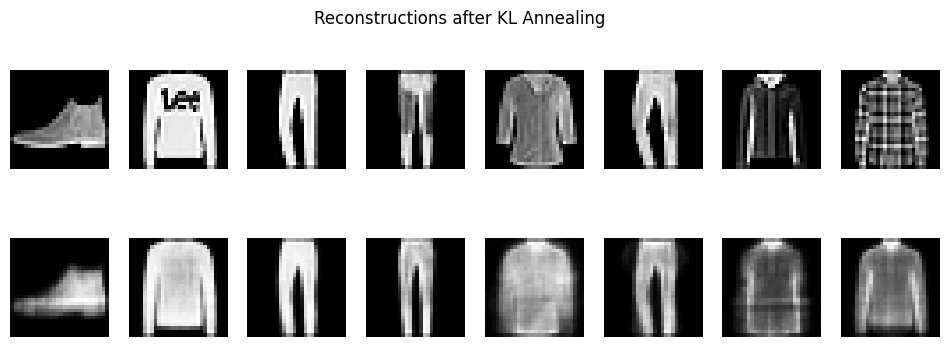

In [16]:
model.eval()
x, _ = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    recon_x, _, _ = model(x)

n = 8
plt.figure(figsize=(12,4))
for i in range(n):
    plt.subplot(2,n,i+1)
    plt.imshow(x[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")
    plt.subplot(2,n,i+1+n)
    plt.imshow(recon_x[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Reconstructions after KL Annealing")
plt.show()


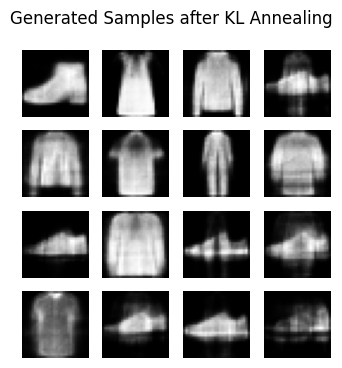

In [17]:
z = torch.randn(16, latent_dim).to(device)
with torch.no_grad():
    samples = model.decode(z)

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Samples after KL Annealing")
plt.show()
